# Content-Based Recommender System using Naive Bayes

This notebook implements two types of content-based recommendation systems using the MovieLens dataset:
1. User-specific recommender using Naive Bayes (user profile models)
2. Global recommender using Kronecker product of user/item features
3. Evaluation methodology for realistic recommendation performance

### Load and Preprocess Data

In [186]:
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from collections import Counter

import random
random.seed(42)

In [187]:
DATA_PATH = "../ml-latest-small"

ratings = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))
movies = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))
tags = pd.read_csv(os.path.join(DATA_PATH, "tags.csv"))

## 🧹 Preprocess Movie Metadata
tags_agg = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies = movies.merge(tags_agg, on="movieId", how="left")
movies["tag"] = movies["tag"].fillna("")
movies["content"] = movies["genres"].str.replace("|", " ") + " " + movies["tag"]

In [188]:
movies.head()

,movieId,title,genres,tag,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,Adventure Animation Children Comedy Fantasy pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game,Adventure Children Fantasy fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old,Comedy Romance moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake


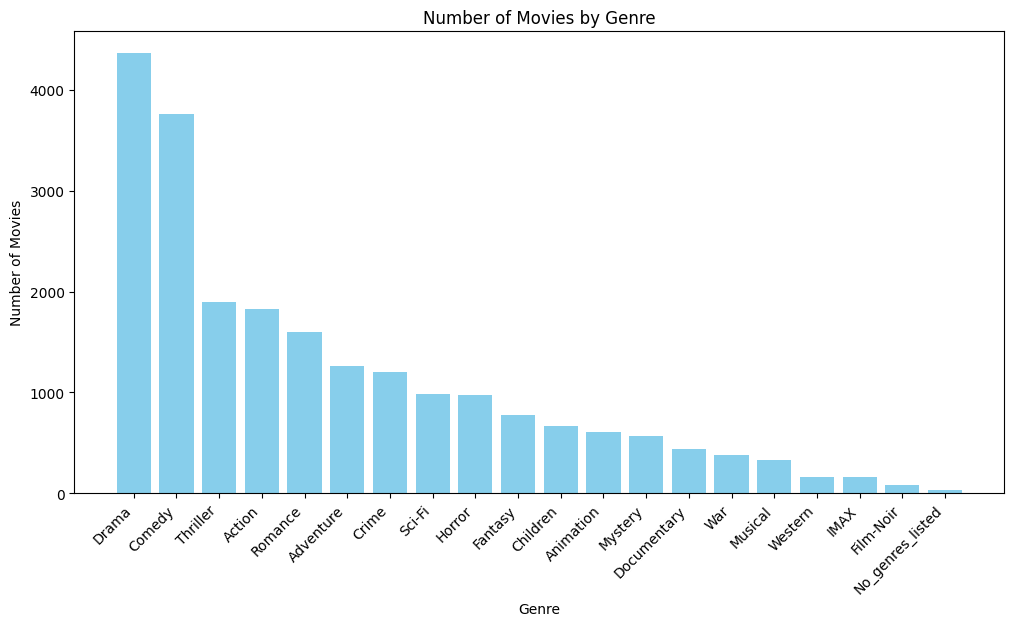

In [189]:
movies_with_genres = movies.copy()
movies_with_genres['genres'] = movies_with_genres['genres'].str.split('|')

# Just for sake of visualization, we replace the class name
movies['genres'] = movies['genres'].replace('(no genres listed)', 'No_genres_listed')

# Creating a list with all genres
all_genres = '|'.join(movies['genres']).split('|')

# Counting all the genres
genre_counts = Counter(all_genres)

# Creating a DataFrame based on the counter
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_df['Genre'], genre_counts_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

In [190]:
print(f"Number of unique tags: {len(tags['tag'].unique())}")

no_tags_count = len(movies[movies["tag"] == ""])
print(f"Number of films without tags: {no_tags_count}")

with_tags_count = len(movies[movies["tag"] != ""])
print(f"Number of films with tags: {with_tags_count}")

Number of unique tags: 1589
Number of films without tags: 8170
Number of films with tags: 1572


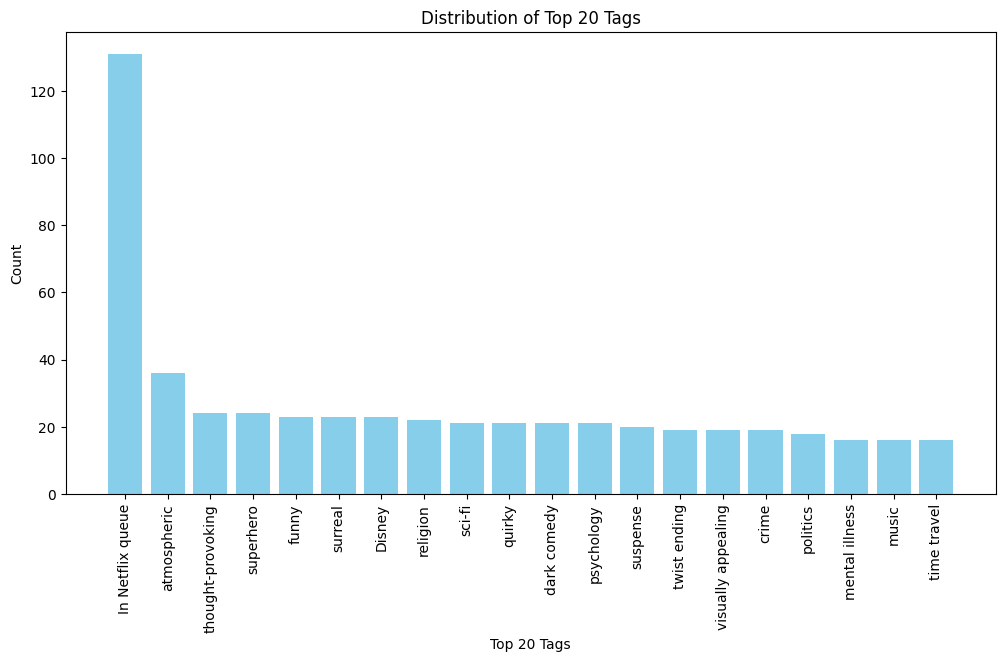

In [191]:
tags_count = tags["tag"].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(tags_count.index[:20], tags_count.values[:20], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Top 20 Tags")
plt.ylabel("Count")
plt.title("Distribution of Top 20 Tags")
plt.show()

## 1. User-Specific Naive Bayes Recommender

The model is trained on metadata including the movie title and genres, with titles cleaned to remove release years.

In [192]:
# Clean the title by removing the year in parentheses
def clean_title(title):
    return re.sub(r'\s*\(\d{4}\)', '', title)

In [193]:
# metadata available for each movie
metadata = movies[["movieId", "title", "genres"]]
metadata.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Removing the year from movie titles helps clean the data for content-based recommendation. The year adds no semantic value for models using text features like TF-IDF and can introduce noise or inflate the vocabulary. By focusing on the actual title, we ensure better feature extraction and more accurate similarity comparisons between movies.

In [194]:
metadata.loc[:, 'title'] = metadata['title'].apply(clean_title)

In [195]:
metadata.head()

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


### Binarize the genres

Binarizing genres turns categorical data into a binary format, making it easier for machine learning models to process. This method helps handle movies with multiple genres and captures interactions between them, improving recommendation accuracy. It simplifies the feature engineering process and ensures the model can effectively learn from genre information.

In [196]:
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(metadata['genres'].str.split('|'))

In [197]:
# Create a DataFrame with the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
genres_df.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [198]:
# Concatenate the original metadata with the encoded genres
metadata = pd.concat([metadata[['movieId', 'title']], genres_df], axis=1)
# metadata = metadata.drop(columns=['(no genres listed)'])
metadata.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [199]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

# Create a preprocessor that transforms the movie metadata:
# - Applies TF-IDF vectorization to the cleaned 'title' column to extract textual features.
# - Passes through the binary genre columns (already transformed by MultiLabelBinarizer).
# - Drops any remaining columns that are not explicitly selected.
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns)
    ],
    remainder='drop'
)

In [200]:
def predict_single_movie(user_id, movie_id):
    # Step 1: Prepare user data
    user_ratings = ratings[ratings['userId'] == user_id]
    user_data = pd.merge(user_ratings, metadata, on='movieId')

    # Step 2: Create binary labels
    user_data['label'] = user_data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    user_data = user_data.dropna(subset=['label'])
    user_data['label'] = user_data['label'].astype(int)

    if user_data.empty:
        print("User has insufficient data.")
        return None

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MultinomialNB())
    ])

    X_train = user_data.drop(columns=['userId', 'rating', 'label', 'timestamp'])
    y_train = user_data['label']

    display(X_train.head())

    pipeline.fit(X_train, y_train)

    # Step 4: Check if the movie has already been watched
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata[metadata['movieId'] == movie_id]
    display(movie_row)

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None

    input_cols = list(X_train.columns)
    movie_features = movie_row[input_cols]

    # Step 6: Predict the probability of liking the movie
    probs = pipeline.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    title = movie_row['title'].values[0]

    return {
        'movieId': movie_id,
        'title': title,
        'score': prob,
        'recommended': prob >= 0.5
    }

In [201]:
chosen_user = random.choice(ratings['userId'].unique())
chosen_film = random.choice(metadata['movieId'].unique())

predict_single_movie(user_id=chosen_user, movie_id=chosen_film)

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western
0,21,Get Shorty,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,32,Twelve Monkeys (a.k.a. 12 Monkeys),0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,34,Babe,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,112,Rumble in the Bronx (Hont faan kui),1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,196,Species,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western
409,471,"Hudsucker Proxy, The",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


{'movieId': 471,
 'title': 'Hudsucker Proxy, The',
 'score': 0.8944694760318904,
 'recommended': True}

## 2. Global Content-Based Recommender (Single Model for All Users)

In [202]:
metadata_with_tags = metadata.merge(movies[["movieId", "tag"]], on='movieId', how='left')
metadata_with_tags.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western,tag
0,1,Toy Story,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,pixar pixar fun
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,moldy old
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,pregnancy remake


In [203]:
preprocessor_global = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns),
        ('tfidf_tag', tfidf, 'tag')
    ],
    remainder='drop'
)

In [204]:
def train_global_model():
    # Step 1: Prepare data
    data = pd.merge(ratings, metadata_with_tags, on='movieId')

    # Step 2: Create binary labels
    data['label'] = data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor_global),
        ('classifier', MultinomialNB())
    ])

    X = data.drop(columns=['userId', 'movieId', 'rating', 'label', 'timestamp'])
    y = data['label']

    display(X.head())

    model = pipeline.fit(X, y)
    return model, X.columns

model_global, train_columns = train_global_model()

def recommend_global(user_id, movie_id):
    # Step 4: Check if the movie has already been watched
    user_ratings = ratings[ratings['userId'] == user_id]
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata_with_tags[metadata_with_tags['movieId'] == movie_id]
    display(movie_row)

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None
    movie_features = movie_row[train_columns]

    # Step 6: Predict the probability of liking the movie
    probs = model_global.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    title = movie_row['title'].values[0]

    return {
        'movieId': movie_id,
        'title': title,
        'score': prob,
        'recommended': prob >= 0.5
    }

,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western,tag
0,Toy Story,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,pixar pixar fun
1,Grumpier Old Men,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,moldy old
2,Heat,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,
3,Seven (a.k.a. Se7en),0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,mystery twist ending serial killer
4,"Usual Suspects, The",0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,mindfuck suspense thriller tricky twist ending heist


In [205]:
recommend_global(user_id=chosen_user, movie_id=chosen_film)

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,IMAX,Musical,Mystery,No_genres_listed,Romance,Sci-Fi,Thriller,War,Western,tag
409,471,"Hudsucker Proxy, The",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,hula hoop


{'movieId': 471,
 'title': 'Hudsucker Proxy, The',
 'score': 0.6270516385090441,
 'recommended': True}